In [3]:
# Load packages
from os import path
import numpy as np
import os
import pandas as pd
import json
from pandas.io.json import json_normalize
import datetime as dt
import matplotlib
#import matplotlib.pyplot as plt
#import seaborn as sns
#%matplotlib inline

In [14]:
def igjsontopandas(jsonfile, filepath):
    with open(jsonfile, encoding = 'utf-8') as f:
        d = json.load(f)
    
    global df
    df = pd.DataFrame()
    df = json_normalize(d['GraphImages'])
    df["caption"] = [df["edge_media_to_caption.edges"][i][0]["node"]['text'] if (len(df["edge_media_to_caption.edges"][i]) > 0) else "" for i in range(len(df))]
    df["taken_at_timestamp"] = [dt.datetime.fromtimestamp(post).strftime("%Y-%m-%d %H:%M:%S") for post in df["taken_at_timestamp"]]
    
    df.to_csv(filepath)

In [211]:
communities = ["utknoxville",
             "utkgeography",
             "tennessee",
             "knoxcounty",
             "downtownknoxville",
             "outdoors",
             "nourishknoxville",
             "sunrisesupermarket",
             "religion",
             "knoxvillepolice"]

#for y in range(len(communities)):
#    igjsontopandas("C:/Users/jfeng/OneDrive - University of Tennessee/GEOG509/Instagram/KDE/{}/{}.json".format(communities[y], communities[y]), "C:/Users/jfeng/OneDrive - University of Tennessee/GEOG509/Instagram/KDE/{}.csv".format(communities[y]))

In [108]:
for y in range(len(communities)):
    df = pd.read_csv("C:/Users/jfeng/OneDrive - University of Tennessee/GEOG509/Instagram/KDE/{}.csv".format(communities[y]), index_col=1)
    locations = pd.DataFrame.from_dict(df["location.address_json"])
    # Get rid of all posts without any location information
    locations = locations[locations["location.address_json"].notnull()]
    # Reset index so numbering starts at 0
    locations = locations.reset_index(drop=True)
    # Convert the location address column, which is being read as a string, into a dictionary
    locations["location.address_json"] = [json.loads(locations["location.address_json"][i]) for i in range(len(locations))]
    # Create separate columns for all keys (address fields)
    locations = pd.DataFrame(locations['location.address_json'].values.tolist(), index=locations.index)
    # Establish the column where the geocoded address will be input
    locations["geocode"] = None
    for i in range(len(locations)):
        if locations["city_name"][i] == "University of Tennessee":
            locations["city_name"][i] = "University of Tennessee at Knoxville"
        if locations["exact_city_match"][i] == True:
            locations["geocode"][i] = locations["city_name"][i] + ", " + locations["country_code"][i]  
        elif locations["exact_region_match"][i] == True:
            locations["geocode"][i] = locations["region_name"][i] + ", " + locations["country_code"][i]
        elif locations["exact_country_match"][i] == True:
            locations["geocode"][i] = locations["country_code"][i]
        elif ((locations["exact_country_match"][i] == False) & (locations["exact_region_match"][i] == False) & (locations["exact_city_match"][i] == False) & (pd.isnull(locations["street_address"][i])) & (pd.isnull(locations["zip_code"][i]))):
            locations["geocode"][i] = locations["city_name"][i] + ", " + locations["country_code"][i] + " " + locations["zip_code"][i]
        elif ((locations["exact_country_match"][i] == False) & (locations["exact_region_match"][i] == False) & (locations["exact_city_match"][i] == False) & (pd.isnull(locations["street_address"][i]))):
            locations["geocode"][i] = locations["city_name"][i] + ", " + locations["country_code"][i]       
        else:
            locations["geocode"][i] = locations["street_address"][i] + ", " + locations["city_name"][i] + ", " + locations["country_code"][i] + " " + locations["zip_code"][i]
    
    # Save to csv
    locations.to_csv("C:/Users/jfeng/OneDrive - University of Tennessee/GEOG509/Instagram/KDE/loc_{}.csv".format(communities[y]))

C:\Users\jfeng\Anaconda3\envs\Instagram\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jfeng\Anaconda3\envs\Instagram\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jfeng\Anaconda3\envs\Instagram\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\jfeng\Anaconda3\envs\

In [68]:
from geopy.geocoders import ArcGIS
geolocator = ArcGIS(username="jfeng12_myUTK",
                    password="roweatread@420",
                    referer="https://www.arcgis.com/sharing/oauth2/token?client_id=SfapFvw8g9Nyjmmt&grant_type=client_credentials&client_secret=462e16278bad4cb59d7411fadcc573c0&f=pjson",
                    token_lifetime=120)
geolocator = ArcGIS(user_agent="GeocodeIG")

In [113]:
for e in range(len(communities)):
    df = pd.read_csv("C:/Users/jfeng/OneDrive - University of Tennessee/GEOG509/Instagram/KDE/loc_{}.csv".format(communities[e]))
    df["ArcGIS_Geocode"] = [geolocator.geocode(df["geocode"][d], timeout=10, out_fields="*") for d in range(len(df))]
    df["ArcGIS_Address"] = [None if pd.isna(df["ArcGIS_Geocode"][g]) else df["ArcGIS_Geocode"][g][0] for g in range(len(df))]
    df["Latitude"] = [None if pd.isna(df["ArcGIS_Geocode"][h]) else df["ArcGIS_Geocode"][h][1][0] for h in range(len(df))]
    df["Longitude"] = [None if pd.isna(df["ArcGIS_Geocode"][z]) else df["ArcGIS_Geocode"][z][1][1] for z in range(len(df))]
    df.to_csv("C:/Users/jfeng/OneDrive - University of Tennessee/GEOG509/Instagram/KDE/loc_{}.csv".format(communities[e]))

In [218]:
df2 = pd.DataFrame(columns=df.columns)
for a in range(len(communities)):
    dftemp = pd.read_csv("C:/Users/jfeng/OneDrive - University of Tennessee/GEOG509/Instagram/KDE/loc_{}.csv".format(communities[a]))
    dftemp["Community"] = [communities[a] for b in range(len(dftemp))]
    df2 = pd.concat([df2, dftemp])
    df2.to_csv("C:/Users/jfeng/OneDrive - University of Tennessee/GEOG509/Instagram/KDE/loc_all.csv")

NameError: name 'df3' is not defined

In [220]:
df2 = pd.read_csv("C:/Users/jfeng/OneDrive - University of Tennessee/GEOG509/Instagram/KDE/loc_all.csv")

In [225]:
df3 = df2[["ArcGIS_Address", "ArcGIS_Geocode", "Community", "Latitude", "Longitude"]]
df3 = df3.rename(columns = {
                     "ArcGIS_Address": "IGAddress",
                     "ArcGIS_Geocode": "ArcGISAddress",
					 "Community": "Community",
                     "Latitude": "Latitude",
                     "Longitude": "Longitude",
                })
# overwriting column with replaced value of age 
df3["Community"] = df3["Community"].replace("utknoxville", "UTK")
df3["Community"] = df3["Community"].replace("utkgeography", "UTK Geography") 
df3["Community"] = df3["Community"].replace("knoxcounty", "Knox County") 
df3["Community"] = df3["Community"].replace("tennessee", "Tennessee") 
df3["Community"] = df3["Community"].replace("outdoors", "Outdoors") 
df3["Community"] = df3["Community"].replace("nourishknoxville", "Nourish Knoxville") 
df3["Community"] = df3["Community"].replace("sunrisesupermarket", "Sunrise Supermarket") 
df3["Community"] = df3["Community"].replace("downtownknoxville", "Downtown Knoxville") 
df3["Community"] = df3["Community"].replace("knoxvillepolice", "Knoxville Police") 
df3["Community"] = df3["Community"].replace("religion", "Religion") 
df3.to_csv("C:/Users/jfeng/OneDrive - University of Tennessee/GEOG509/Instagram/KDE/loc_all_final.csv")

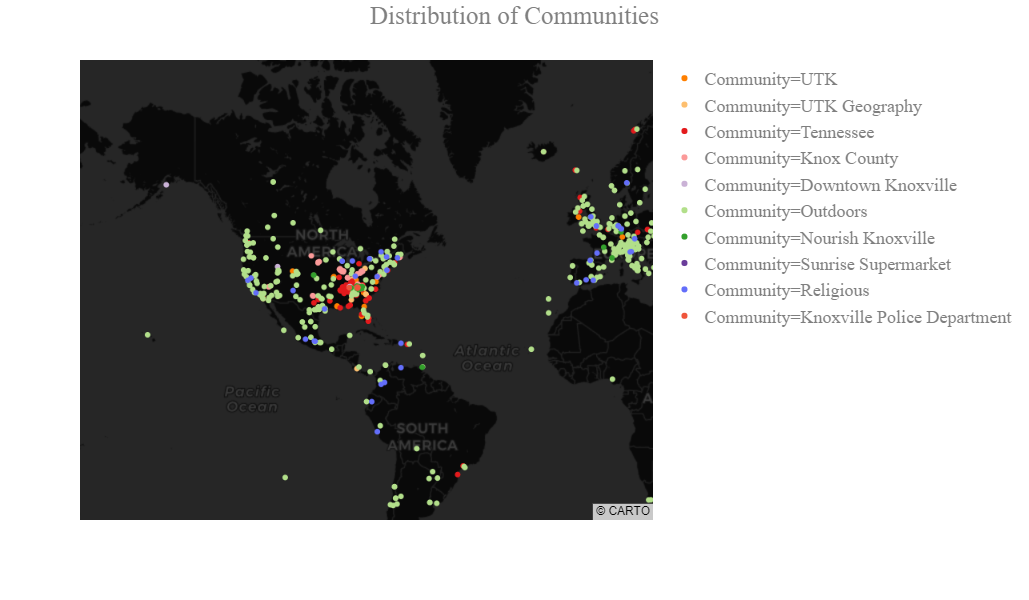

TypeError: write_image() got an unexpected keyword argument 'length'

In [12]:
import plotly.express as px
import pandas as pd


## SETTING UP DASH OFFLINE TO WORK WITH JUPYTER NOTEBOOKS:
## https://github.com/plotly/plotly.py#jupyterlab-support-python-35

df = pd.read_csv("./Instagram/KDE/loc_all_final.csv", index_col = 0)

fig=px.scatter_mapbox(
                data_frame = df,
                lon = df['Longitude'], 
                lat = df['Latitude'],
                color = df['Community'],
                hover_name = df['ArcGISAddress'],
                size_max = 20,
                zoom = 1,
                color_discrete_map = {
                    'UTK': 'rgb(255,127,0)',
                    'UTK Geography': 'rgb(253,191,111)',
                    'Knox County': 'rgb(251,154,153)',
                    'Tennessee': 'rgb(227,26,28)',
                    'Outdoors': 'rgb(178,223,138)',
                    'Nourish Knoxville': 'rgb(51,160,44)',
                    'Sunrise Supermarket': 'rgb(106,61,154)',
                    'Downtown Knoxville': 'rgb(202,178,214)',
                    'Knoxville Police': 'rgb(31,120,180)',
                    'Religion': 'rgb(166,206,227)',
                    
                }
                )

fig.update_layout(
    title = dict(
        text = "Distribution of Communities",
        y = 0.99,
        x = 0.5,
        xanchor = 'center',
        yanchor = 'top'
    ),
    xaxis_title = "Longtiude",
    yaxis_title = "Latitude",
    legend = dict(
        font = dict(
            family = "Droid Serif"),
    ),
    mapbox_accesstoken = 'pk.eyJ1IjoiamZlbmduZ3MiLCJhIjoiY2p6Ym1iNWo4MDB1cTNicDRzcGQ2eGF1NSJ9.Ezuinvb1KJWFvQwaQj7u1A',
    mapbox_style = 'carto-darkmatter',
    mapbox = dict(
        #style = 'stamen-toner',
        center = dict(
            lon = -80.8431,
            lat = 35.2271
        )
    ),
    font = dict(
        family = "Droid Serif",
        size = 18,
        color = "#7f7f7f"
    ),
    geo = dict(
        subunitcolor = 'forestgreen'
    )
)

fig.show()

fig.write_image("C:/Users/jfeng/OneDrive - University of Tennessee/GEOG509/distofcomm.png", width = 4800, length = 3200, scale=5)

In [10]:
fig.write_image("C:/Users/jfeng/OneDrive - University of Tennessee/GEOG509/distofcomm.jpeg")

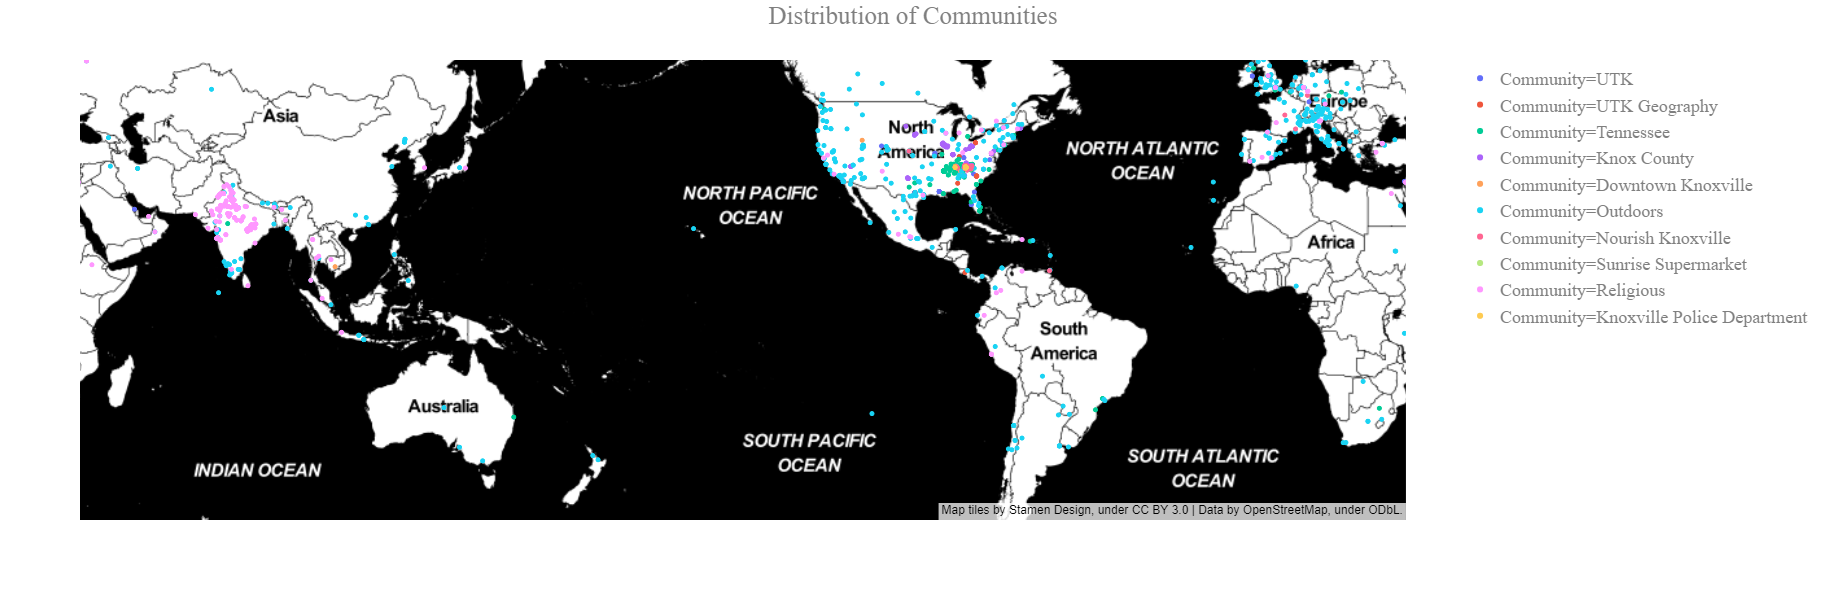

In [3]:
import plotly.graph_objects as go

fig=go.Densitymapbox(
                data_frame = df,
                lon = df['Longitude'], 
                lat = df['Latitude'],
                color = df['Community'],
                hover_name = df['ArcGISAddress'],
                size_max = 20,
                zoom = 1,
                )

fig.update_layout(
    title = dict(
        text = "Distribution of Communities",
        y = 0.99,
        x = 0.5,
        xanchor = 'center',
        yanchor = 'top'
    ),
    xaxis_title = "Longtiude",
    yaxis_title = "Latitude",
    legend = dict(
        font = dict(
            family = "Droid Serif"),
    ),
    mapbox_accesstoken = 'pk.eyJ1IjoiamZlbmduZ3MiLCJhIjoiY2p6Ym1iNWo4MDB1cTNicDRzcGQ2eGF1NSJ9.Ezuinvb1KJWFvQwaQj7u1A',
    mapbox_style = 'stamen-toner',
    mapbox = dict(
        #style = 'stamen-toner',
        center = dict(
            lon = -80.8431,
            lat = 35.2271
        )
    ),
    font = dict(
        family = "Droid Serif",
        size = 18,
        color = "#7f7f7f"
    ),
    geo = dict(
        subunitcolor = 'forestgreen'
    )
)

fig.show()